In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import scipy.optimize as opt

In [2]:
wing_area = 0.007313 # m^2
mac = 0.03382264 # m

In [3]:
calib_data = pd.read_csv('data/calib.csv')
calib_aoa = calib_data['Angle of Attack (deg)']
calib_axial = calib_data['Axial Force (Lbf)'] * 4.44822 # N
calib_norm = calib_data['Normal Force (Lbf)'] * 4.44822 # N
calib_moment = calib_data['Pitching Mom (in-Lbf)'] * 0.112984829 # Nm

In [4]:
speed_10_data = pd.read_csv('data/speed_10ms.csv')
speed_10_aoa = speed_10_data['Angle of Attack (deg)']
speed_10_axial = speed_10_data['Axial Force (Lbf)'] * 4.44822 # N
speed_10_norm = speed_10_data['Normal Force (Lbf)'] * 4.44822 # N
speed_10_moment = speed_10_data['Pitching Mom (in-Lbf)'] * 0.112984829 #Nm
speed_10_dens = speed_10_data['Density (slug/ft3)'] * 515.378818 # kg/m^3
speed_10_vel = speed_10_data['Avg Velocity (ft/s)'] * 0.3048 # m/s
speed_10_visc = speed_10_data['Viscosity (slug/ft s)'] * 47.880259 # kg/m s
speed_10_q = speed_10_data['Corrected q (dpsi)'] * 6894.76

speed_10_re = speed_10_vel * mac * speed_10_dens / speed_10_visc

In [5]:
speed_20_data = pd.read_csv('data/speed_20ms.csv')
speed_20_aoa = speed_20_data['Angle of Attack (deg)']
speed_20_axial = speed_20_data['Axial Force (Lbf)'] * 4.44822
speed_20_norm = speed_20_data['Normal Force (Lbf)'] * 4.44822
speed_20_moment = speed_20_data['Pitching Mom (in-Lbf)'] * 0.112984829
speed_20_dens = speed_20_data['Density (slug/ft3)'] * 515.378818
speed_20_vel = speed_20_data['Avg Velocity (ft/s)'] * 0.3048
speed_20_visc = speed_20_data['Viscosity (slug/ft s)'] * 47.880259 # kg/m s
speed_20_q = speed_20_data['Corrected q (dpsi)'] * 6894.76

speed_20_re = speed_20_vel * mac * speed_20_dens / speed_20_visc

In [6]:
speed_30_data = pd.read_csv('data/speed_30ms.csv')
speed_30_aoa = speed_30_data['Angle of Attack (deg)']
speed_30_axial = speed_30_data['Axial Force (Lbf)'] * 4.44822
speed_30_norm = speed_30_data['Normal Force (Lbf)'] * 4.44822
speed_30_moment = speed_30_data['Pitching Mom (in-Lbf)'] * 0.112984829
speed_30_dens = speed_30_data['Density (slug/ft3)'] * 515.378818
speed_30_vel = speed_30_data['Avg Velocity (ft/s)'] * 0.3048
speed_30_visc = speed_30_data['Viscosity (slug/ft s)'] * 47.880259 # kg/m s
speed_30_q = speed_30_data['Corrected q (dpsi)'] * 6894.76

speed_30_re = speed_30_vel * mac * speed_30_dens / speed_30_visc

In [7]:
def get_l_d(aoa, axial, norm):
    l = norm * np.cos(np.deg2rad(aoa)) - axial * np.sin(np.deg2rad(aoa))
    d = norm * np.sin(np.deg2rad(aoa)) + axial * np.cos(np.deg2rad(aoa))
    return l, d

In [8]:
get_calib_axial = interp.interp1d(calib_aoa, calib_axial, bounds_error=False, fill_value='extrapolate')
get_calib_norm = interp.interp1d(calib_aoa, calib_norm, bounds_error=False, fill_value='extrapolate')
get_calib_moment = interp.interp1d(calib_aoa, calib_moment, bounds_error=False, fill_value='extrapolate')

for i in range(len(speed_10_aoa)):
    speed_10_axial[i] -= get_calib_axial(speed_10_aoa[i])
    speed_10_norm[i] -= get_calib_norm(speed_10_aoa[i])
    speed_10_moment[i] -= get_calib_moment(speed_10_aoa[i])

for i in range(len(speed_20_aoa)):
    speed_20_axial[i] -= get_calib_axial(speed_20_aoa[i])
    speed_20_norm[i] -= get_calib_norm(speed_20_aoa[i])
    speed_20_moment[i] -= get_calib_moment(speed_20_aoa[i])

for i in range(len(speed_30_aoa)):
    speed_30_axial[i] -= get_calib_axial(speed_30_aoa[i])
    speed_30_norm[i] -= get_calib_norm(speed_30_aoa[i])
    speed_30_moment[i] -= get_calib_moment(speed_30_aoa[i])


def neutral_point(aoa, norm, moment, re):
    plt.figure(figsize=(10, 10))
    points = np.linspace(0, 0.206248, 10)
    derivs = []
    for i in points:
        derivative = np.average(np.abs(np.gradient(moment - i * norm, aoa)))
        derivs.append(derivative)
        plt.plot(aoa, moment - i*norm, label=f'x = {i:.3f}m',marker='o')
    plt.title(f'Pitching Moment vs Angle of Attack at Various Distances from Sting at Re = {np.average(re):.0f}')
    plt.xlabel('Angle of Attack (deg)')
    plt.ylabel('Pitching Moment (Nm)')
    plt.legend()
    plt.grid()
    plt.show()
    
    points = np.linspace(0, 0.206248, 1000)
    derivs = []
    for i in points:
        derivative = np.average(np.abs(np.gradient(moment - i * norm, aoa)))
        derivs.append(derivative)

    idx = np.where(derivs == np.min(derivs))[0][0]
    neutral_point = points[idx]
    plt.figure(figsize=(5, 5))
    plt.plot(points, derivs, label='|dM/dalpha|')
    plt.axvline(neutral_point, color='r', label=f"Neutral Point = {neutral_point:.3f}m")
    plt.title(f'dM/dalpha vs Distance from Sting at Re = {np.average(re):.0f}')
    plt.xlabel('x (m)')
    plt.ylabel('dM/dalpha')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"Distance from sting: {neutral_point*1000:.0f}mm")
    print(f"Distance from nose: {(0.206248 - neutral_point)*1000:.0f}mm")
    return neutral_point


In [9]:
l_10, d_10 = get_l_d(speed_10_aoa, speed_10_axial, speed_10_norm)
l_20, d_20 = get_l_d(speed_20_aoa, speed_20_axial, speed_20_norm)
l_30, d_30 = get_l_d(speed_30_aoa, speed_30_axial, speed_30_norm)

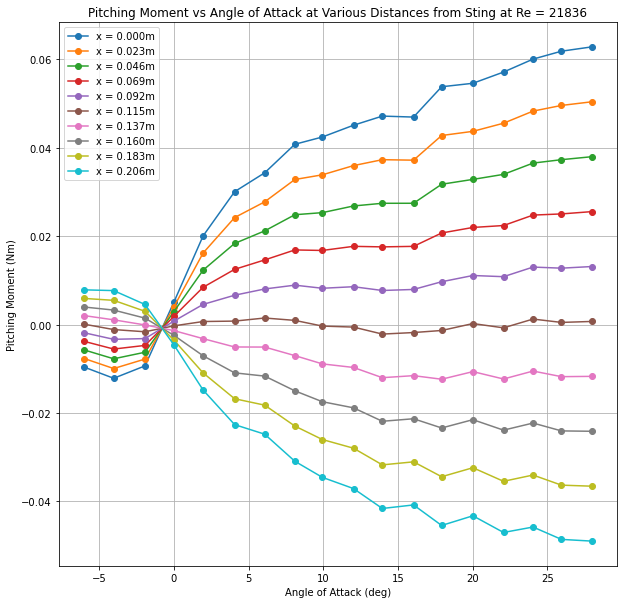

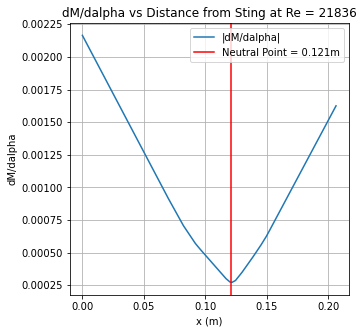

Distance from sting: 121mm
Distance from nose: 85mm


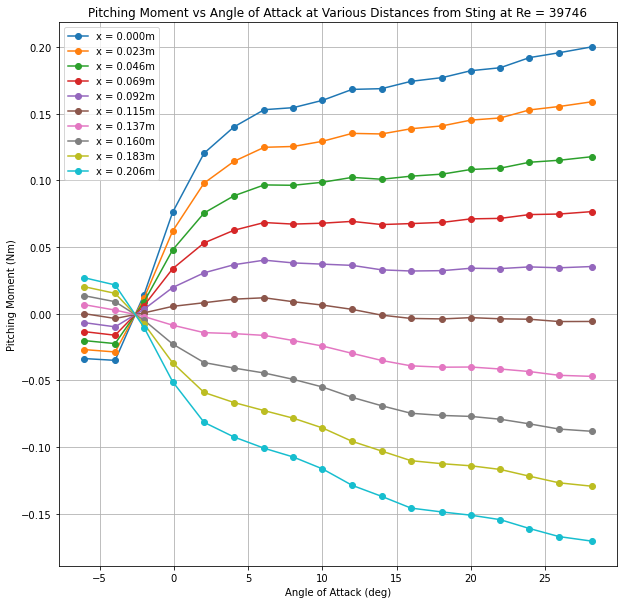

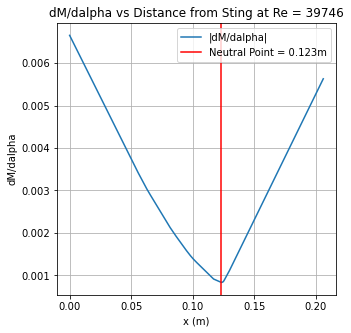

Distance from sting: 123mm
Distance from nose: 83mm


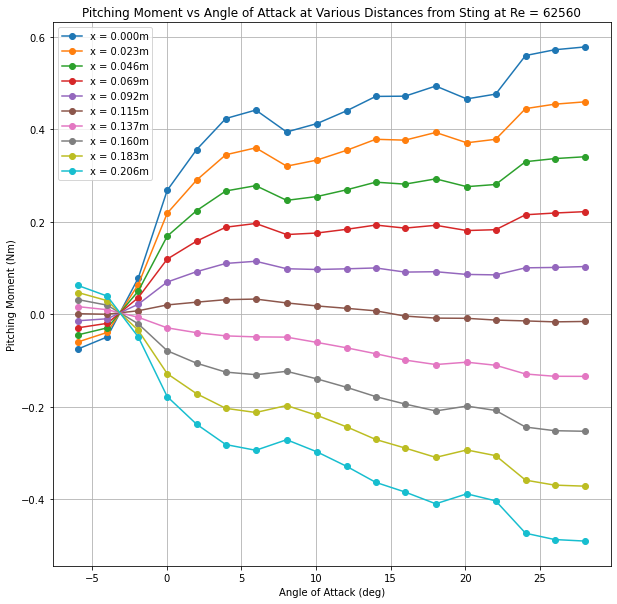

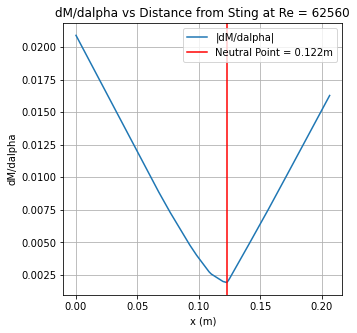

Distance from sting: 122mm
Distance from nose: 84mm


In [10]:
cl_10 = l_10 / (speed_10_q * wing_area)
cl_20 = l_20 / (speed_20_q * wing_area)
cl_30 = l_30 / (speed_30_q * wing_area)

cd_10 = d_10 / (speed_10_q * wing_area)
cd_20 = d_20 / (speed_20_q * wing_area)
cd_30 = d_30 / (speed_30_q * wing_area)

neutral_point_10 = neutral_point(speed_10_aoa, speed_10_norm, speed_10_moment, speed_10_re)
neutral_point_20 = neutral_point(speed_20_aoa, speed_20_norm, speed_20_moment, speed_20_re)
neutral_point_30 = neutral_point(speed_30_aoa, speed_30_norm, speed_30_moment, speed_30_re)

cm_10 = (speed_10_moment - speed_10_norm * neutral_point_10) / (speed_10_q * wing_area * mac)
cm_20 = (speed_20_moment - speed_20_norm * neutral_point_20) / (speed_20_q * wing_area * mac)
cm_30 = (speed_30_moment - speed_30_norm * neutral_point_30) / (speed_30_q * wing_area * mac)

In [11]:
def plot_trials(aoa, cl, cd, cm, re, markers, linestyles):
    plt.figure(figsize=(5, 5))
    plt.axhline(0, lw=2,color='k')
    plt.axvline(0, lw=2,color='k')
    for i in range(len(aoa)):
        plt.plot(aoa[i], cl[i], label=f'Re = {np.average(re[i]):.0f}', marker=markers[i], linestyle=linestyles[i])
    plt.xlabel('Angle of Attack (deg)')
    plt.ylabel(r'$C_L$')
    plt.title(r'$C_L$vs $\alpha$')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.axhline(0, lw=2,color='k')
    plt.axvline(0, lw=2,color='k')
    for i in range(len(aoa)):
        plt.plot(aoa[i], cd[i], label=f'Re = {np.average(re[i]):.0f}', marker=markers[i], linestyle=linestyles[i])
    plt.xlabel('Angle of Attack (deg)')
    plt.ylabel(r'$C_D$')
    plt.title(r'$C_D$ vs $\alpha$')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.axhline(0, lw=2,color='k')
    plt.axvline(0, lw=2,color='k')
    for i in range(len(aoa)):
        plt.plot(aoa[i], cm[i], label=f'Re = {np.average(re[i]):.0f}', marker=markers[i], linestyle=linestyles[i])
    plt.xlabel('Angle of Attack (deg)')
    plt.ylabel(r'$C_M$')
    plt.title(r'$C_M$ vs $\alpha$')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.axhline(0, lw=2,color='k')
    plt.axvline(0, lw=2,color='k')
    for i in range(len(aoa)):
        plt.plot(aoa[i], cl[i]/cd[i], label=f'Re = {np.average(re[i]):.0f}', marker=markers[i], linestyle=linestyles[i])
    plt.xlabel('Angle of Attack (deg)')
    plt.ylabel(r'$L/D$')
    plt.title(r'$L/D$ vs $\alpha$')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.axhline(0, lw=2,color='k')
    plt.axvline(0, lw=2,color='k')
    for i in range(len(aoa)):
        plt.plot(cd[i], cl[i], label=f'Re = {np.average(re[i]):.0f}', marker=markers[i], linestyle=linestyles[i])
    plt.xlabel(r'$C_D$')
    plt.ylabel(r'$C_L$')
    plt.title(r'$C_L$ vs $C_D$')
    plt.legend()
    plt.grid()
    plt.show()

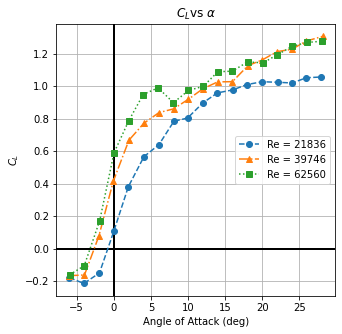

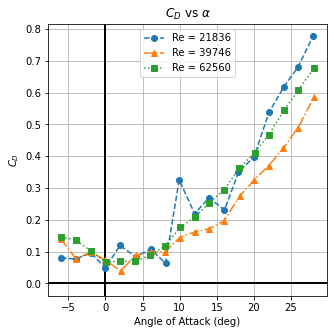

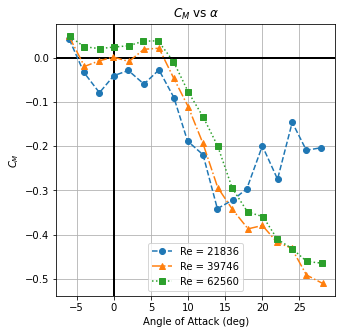

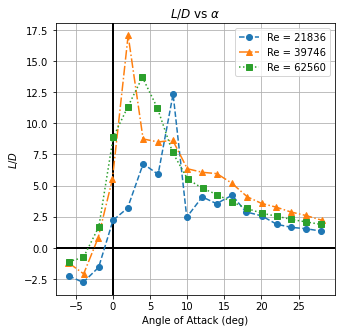

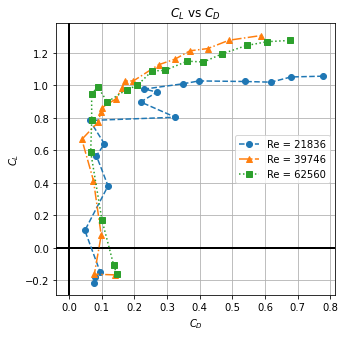

In [12]:
aoa_list = [speed_10_aoa, speed_20_aoa, speed_30_aoa]
cl_list = [cl_10, cl_20, cl_30]
cd_list = [cd_10, cd_20, cd_30]
cm_list = [cm_10, cm_20, cm_30]
re_list = [speed_10_re, speed_20_re, speed_30_re]

plot_trials(aoa_list, cl_list, cd_list, cm_list, re_list, ['o', '^', 's'], ['--', '-.', ':'])

In [13]:
sim_data = pd.read_csv('data/sim_data.csv')
sim_cl = sim_data["CL"]
sim_cd = sim_data["CD"]
sim_cm = sim_data["CM3"]

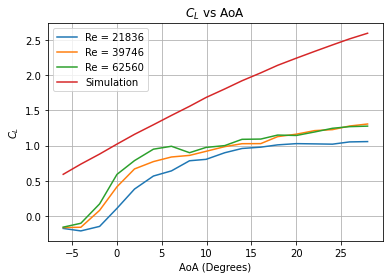

In [14]:
plt.plot(np.array(aoa_list[0]), np.array(cl_10), label="Re = 21836")
plt.plot(np.array(aoa_list[0]), np.array(cl_20), label="Re = 39746")
plt.plot(np.array(aoa_list[0]), np.array(cl_30), label="Re = 62560")
plt.plot(np.array(aoa_list[0]), np.array(sim_cl), label="Simulation")
plt.legend()
plt.xlabel("AoA (Degrees)")
plt.ylabel("$C_L$")
plt.title("$C_L$ vs AoA")
plt.grid()

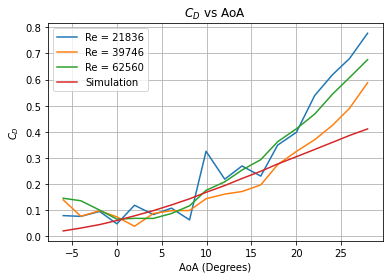

In [15]:
plt.plot(np.array(aoa_list[0]), np.array(cd_10), label="Re = 21836")
plt.plot(np.array(aoa_list[0]), np.array(cd_20), label="Re = 39746")
plt.plot(np.array(aoa_list[0]), np.array(cd_30), label="Re = 62560")
plt.plot(np.array(aoa_list[0]), np.array(sim_cd), label="Simulation")
plt.legend()
plt.xlabel("AoA (Degrees)")
plt.ylabel("$C_D$")
plt.title("$C_D$ vs AoA")
plt.grid()

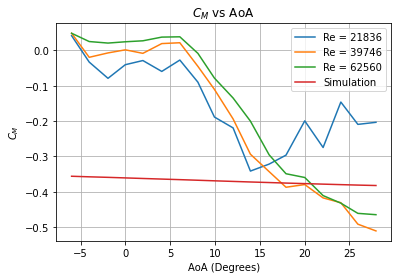

In [16]:
plt.plot(np.array(aoa_list[0]), np.array(cm_10), label="Re = 21836")
plt.plot(np.array(aoa_list[0]), np.array(cm_20), label="Re = 39746")
plt.plot(np.array(aoa_list[0]), np.array(cm_30), label="Re = 62560")
plt.plot(np.array(aoa_list[0]), np.array(sim_cm), label="Simulation")
plt.legend()
plt.xlabel("AoA (Degrees)")
plt.ylabel("$C_M$")
plt.title("$C_M$ vs AoA")
plt.grid()

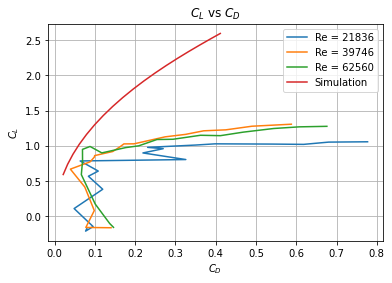

In [17]:
plt.plot(np.array(cd_10), np.array(cl_10), label="Re = 21836")
plt.plot(np.array(cd_20), np.array(cl_20), label="Re = 39746")
plt.plot(np.array(cd_30), np.array(cl_30), label="Re = 62560")
plt.plot(np.array(sim_cd), np.array(sim_cl), label="Simulation")
plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.title("$C_L$ vs $C_D$")
plt.grid()